✓ Successfully loaded with separator: ','

Dataset: 5000 rows × 9 columns
Columns: ['id', 'code', 'question', 'answer', 'prediction', 'accuracy', 'completeness', 'relevance', 'clarity']

Question type distribution:
question_type
When        700
Where       700
For what    700
How         699
What        699
Yes/No      636
Other       406
In which    358
Why         102

Generating visualizations...



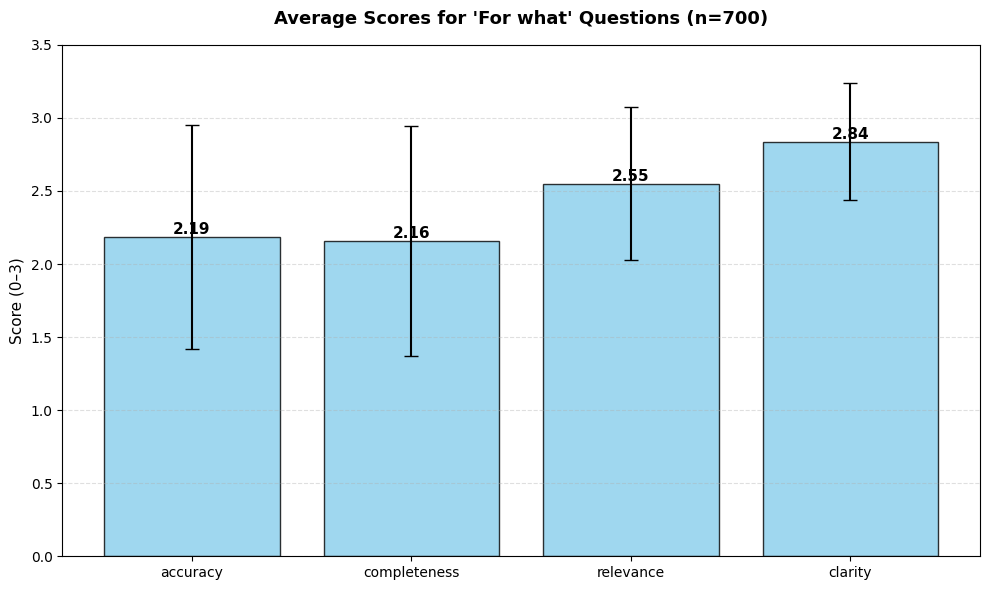

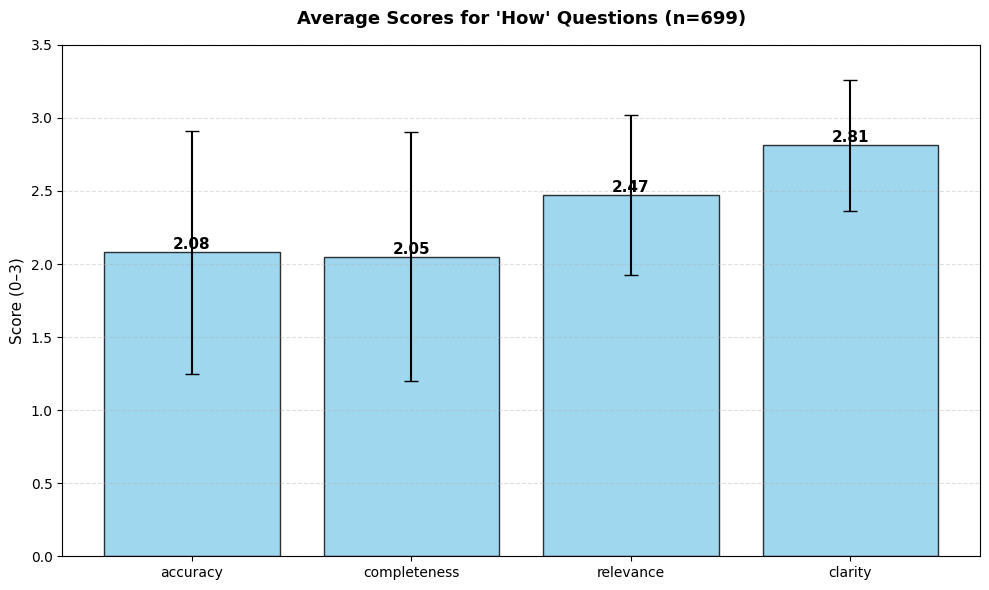

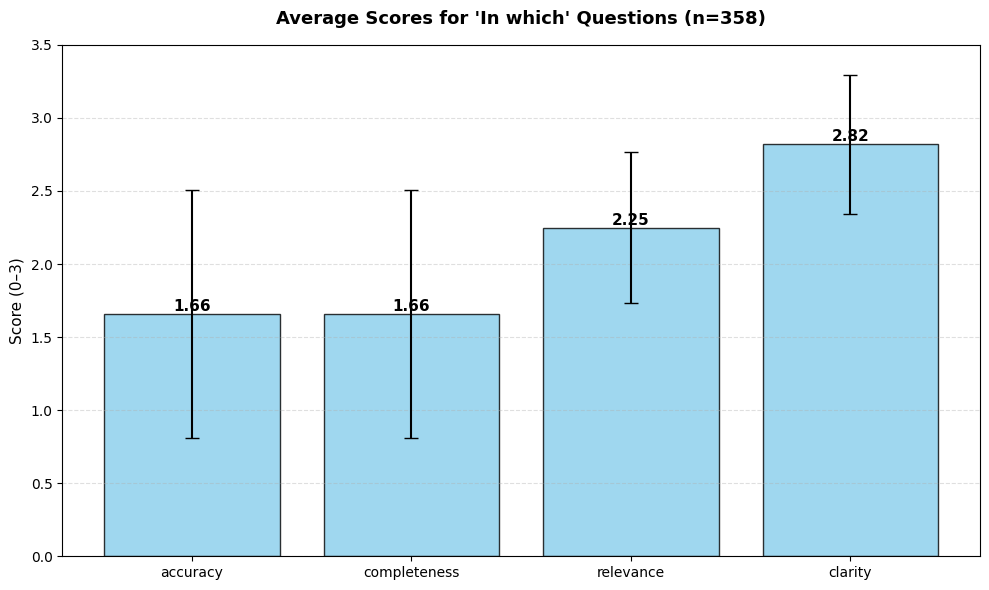

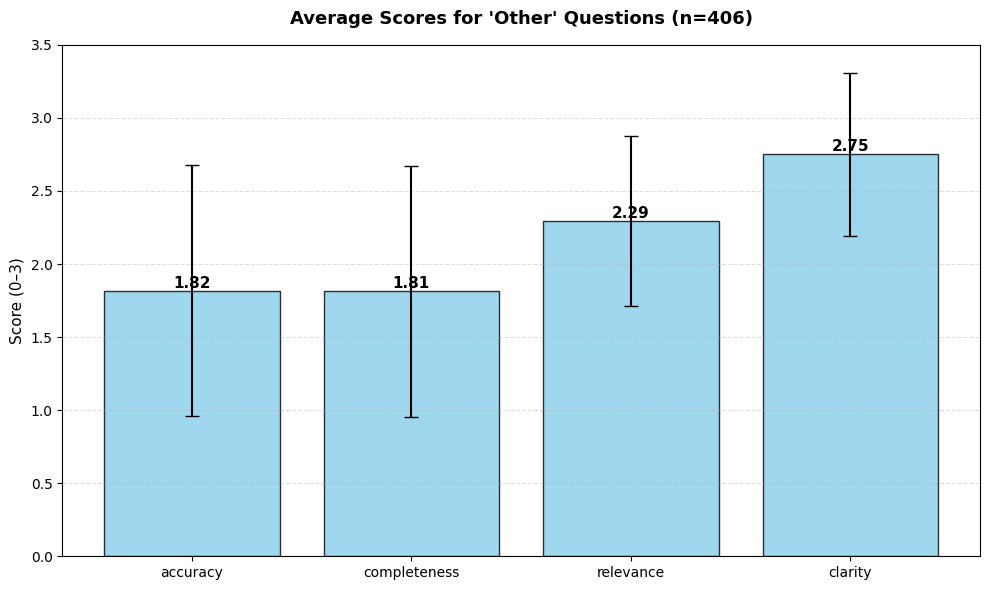

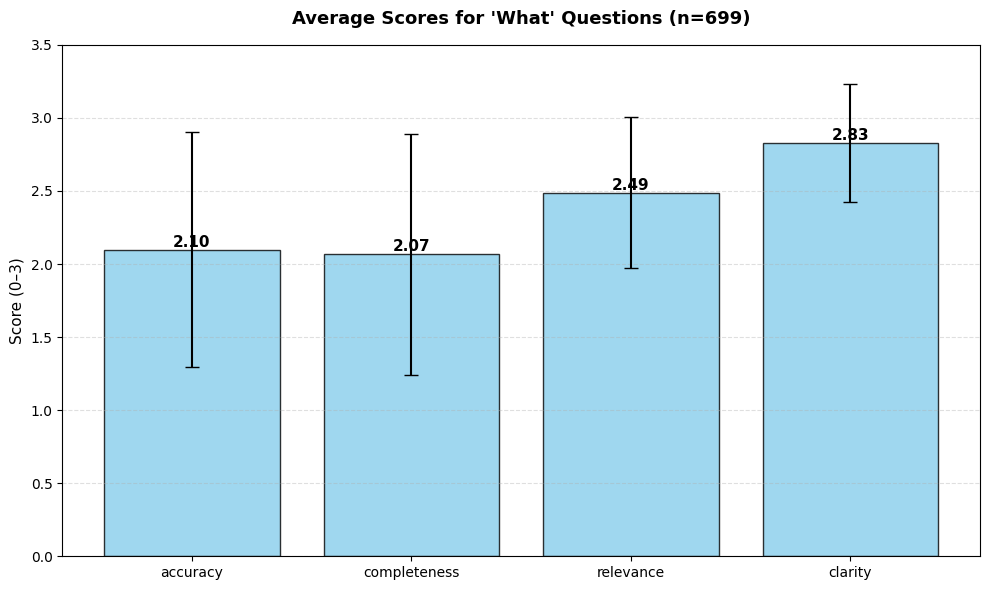

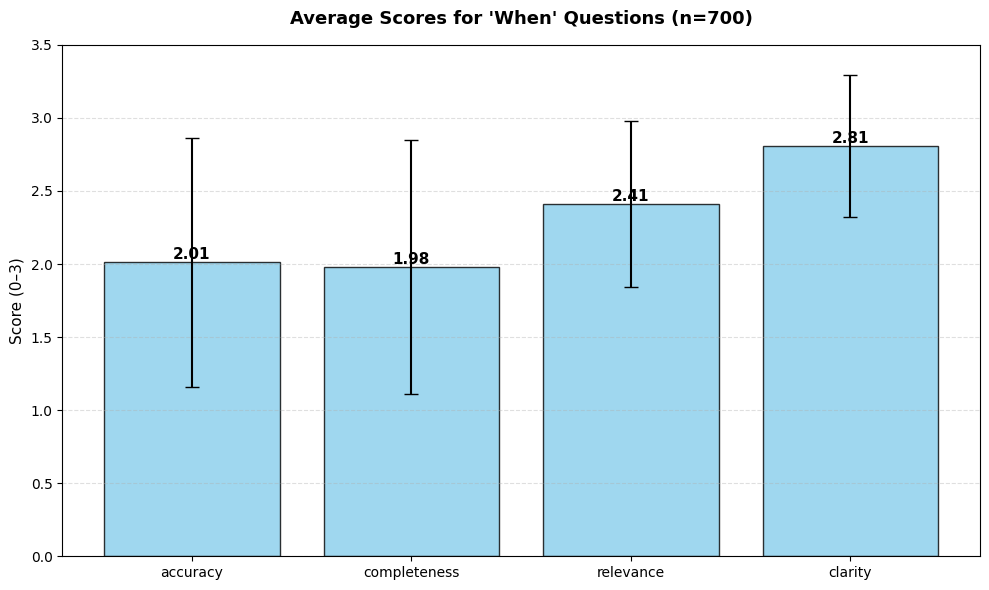

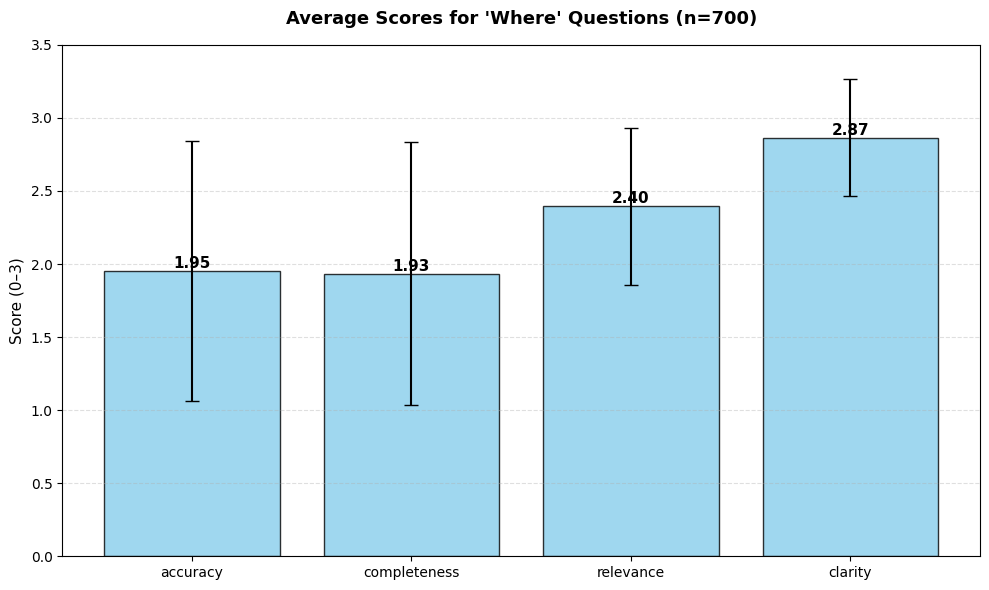

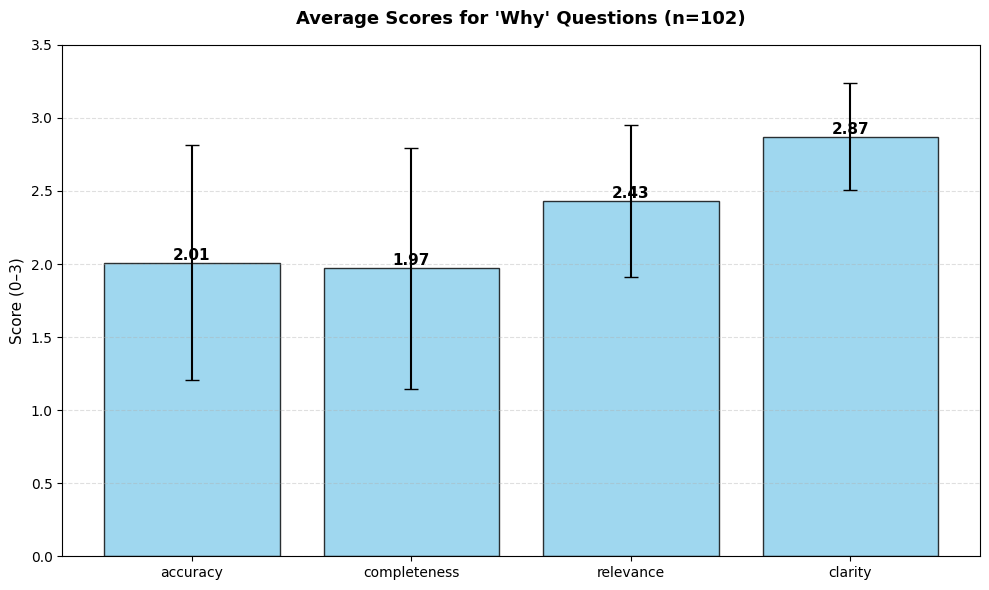

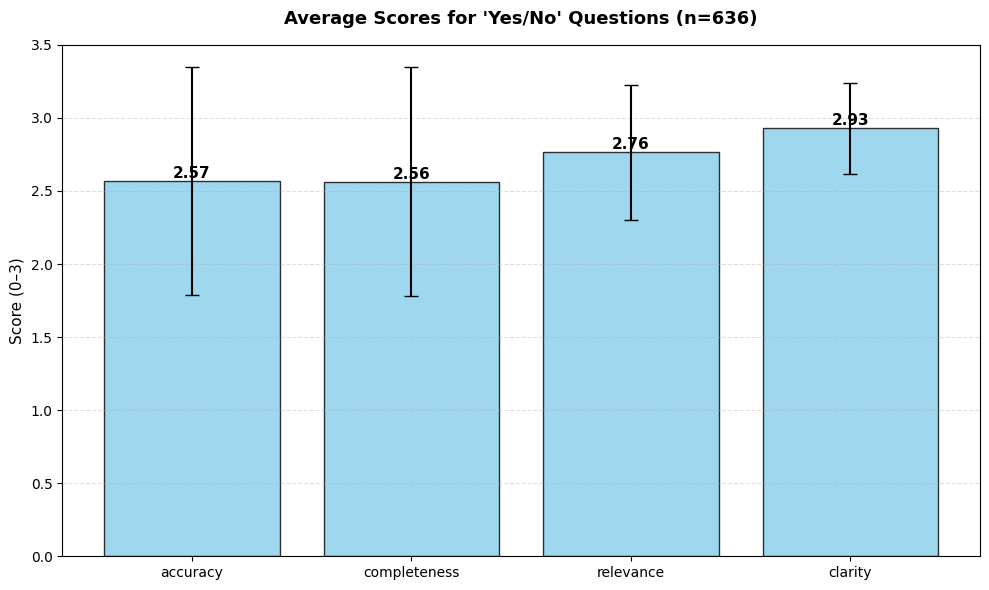


SUMMARY STATISTICS BY QUESTION TYPE
Question Type  Count     Accuracy Completeness    Relevance      Clarity
     For what    700 2.19 (±0.76) 2.16 (±0.79) 2.55 (±0.53) 2.84 (±0.40)
        Where    700 1.95 (±0.89) 1.93 (±0.90) 2.40 (±0.54) 2.87 (±0.40)
         When    700 2.01 (±0.85) 1.98 (±0.87) 2.41 (±0.57) 2.81 (±0.49)
          How    699 2.08 (±0.83) 2.05 (±0.85) 2.47 (±0.55) 2.81 (±0.45)
         What    699 2.10 (±0.80) 2.07 (±0.83) 2.49 (±0.52) 2.83 (±0.41)
       Yes/No    636 2.57 (±0.78) 2.56 (±0.78) 2.76 (±0.46) 2.93 (±0.31)
        Other    406 1.82 (±0.86) 1.81 (±0.86) 2.29 (±0.58) 2.75 (±0.56)
     In which    358 1.66 (±0.85) 1.66 (±0.85) 2.25 (±0.52) 2.82 (±0.48)
          Why    102 2.01 (±0.80) 1.97 (±0.83) 2.43 (±0.52) 2.87 (±0.36)

OVERALL STATISTICS:
-----------------------------------------------------------------------------------------------
Accuracy       : 2.08 (±0.86)
Completeness   : 2.06 (±0.87)
Relevance      : 2.47 (±0.55)
Clarity        : 2.84 (±0.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load the dataset ===
# Try different separators to load the CSV
loaded = False
separators = ['\t', ',', ';', '|']

for sep in separators:
    try:
        df = pd.read_csv("cs1qa_mistral_student.csv", sep=sep, encoding='utf-8')
        # Check if we have the expected columns
        if 'question' in df.columns and 'accuracy' in df.columns:
            print(f"✓ Successfully loaded with separator: {repr(sep)}")
            loaded = True
            break
    except:
        continue

if not loaded:
    # Try auto-detection as fallback
    df = pd.read_csv("cs1qa_mistral_student.csv", sep=None, engine='python', encoding='utf-8')
    print("✓ Loaded with auto-detected separator")

print(f"\nDataset: {len(df)} rows × {len(df.columns)} columns")
print(f"Columns: {df.columns.tolist()}\n")

# === Step 2: Classify question types based on question content ===
def classify_question_type(q):
    q_lower = str(q).lower()
    
    # Check question patterns
    if q_lower.startswith("what"):
        return "What"
    elif q_lower.startswith("how"):
        return "How"
    elif q_lower.startswith("where"):
        return "Where"
    elif q_lower.startswith("when"):
        return "When"
    elif q_lower.startswith("why"):
        return "Why"
    elif q_lower.startswith("in which"):
        return "In which"
    elif q_lower.startswith("for what"):
        return "For what"
    elif q_lower.startswith(("does", "do", "is", "are", "can", "will")):
        return "Yes/No"
    else:
        return "Other"

df['question_type'] = df['question'].apply(classify_question_type)

print("Question type distribution:")
print(df['question_type'].value_counts().to_string())
print()

# === Step 3: Ensure score columns are numeric ===
metrics = ["accuracy", "completeness", "relevance", "clarity"]

# Handle 'completen' column (appears to be truncated in your data)
if 'completen' in df.columns and 'completeness' not in df.columns:
    df['completeness'] = df['completen']
    print("Note: Using 'completen' column as 'completeness'")

for metric in metrics:
    if metric in df.columns:
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
    else:
        print(f"Warning: '{metric}' column not found")

# === Step 4: Generate plots for each question type ===
def visualize_scores(subset, qtype, metrics):
    # Filter metrics that exist in the dataframe
    available_metrics = [m for m in metrics if m in subset.columns]
    
    if not available_metrics:
        print(f"No metrics available for {qtype}")
        return
    
    avg_scores = []
    std_scores = []
    
    for metric in available_metrics:
        avg_scores.append(subset[metric].mean())
        std_scores.append(subset[metric].std())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        available_metrics,
        avg_scores,
        yerr=std_scores,
        capsize=5,
        color='skyblue',
        edgecolor='black',
        alpha=0.8
    )
    
    # Add value labels on bars
    for bar, val, std in zip(bars, avg_scores, std_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title(f"Average Scores for '{qtype}' Questions (n={len(subset)})", 
              fontsize=13, fontweight='bold', pad=15)
    plt.ylabel("Score (0–3)", fontsize=11)
    plt.ylim(0, 3.5)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Generate plots for each question type with at least 2 examples
print("Generating visualizations...\n")
for qtype, subset in df.groupby("question_type"):
    if len(subset) >= 2:  # Only plot if we have at least 2 examples
        visualize_scores(subset, qtype, metrics)
    else:
        print(f"Skipping '{qtype}' - only {len(subset)} example(s)")

# === Step 5: Create a summary table ===
summary = []
for qtype, subset in df.groupby("question_type"):
    row = {"Question Type": qtype, "Count": len(subset)}
    
    for metric in metrics:
        if metric in df.columns:
            mean_val = subset[metric].mean()
            std_val = subset[metric].std()
            if pd.notna(mean_val):
                if pd.notna(std_val):
                    row[metric.capitalize()] = f"{mean_val:.2f} (±{std_val:.2f})"
                else:
                    row[metric.capitalize()] = f"{mean_val:.2f} (±0.00)"
            else:
                row[metric.capitalize()] = "N/A"
        else:
            row[metric.capitalize()] = "N/A"
    
    summary.append(row)

summary_df = pd.DataFrame(summary)

# Sort by count (descending)
summary_df = summary_df.sort_values('Count', ascending=False)

# Reorder columns
column_order = ["Question Type", "Count", "Accuracy", "Completeness", "Relevance", "Clarity"]
available_columns = [col for col in column_order if col in summary_df.columns]
summary_df = summary_df[available_columns]

# === Display the table ===
print("\n" + "="*95)
print("SUMMARY STATISTICS BY QUESTION TYPE")
print("="*95)
print(summary_df.to_string(index=False))
print("="*95)

# Calculate overall statistics
print("\nOVERALL STATISTICS:")
print("-" * 95)
for metric in metrics:
    if metric in df.columns:
        mean_val = df[metric].mean()
        std_val = df[metric].std()
        print(f"{metric.capitalize():15s}: {mean_val:.2f} (±{std_val:.2f})")
print("-" * 95)

# Save results
summary_df.to_csv("cs1qa_summary.csv", index=False)
print("\n✓ Summary saved to 'cs1qa_summary.csv'")

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Load the dataset ===
with open("cs1qa_mistral_student.csv", "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# === Step 2: Classify question types ===
def classify_question_type(q):
    if q.startswith("code_understanding"):
        return "Code Understanding"
    elif q.startswith("logical"):
        return "Logical Error"
    elif q.startswith("error"):
        return "Error"
    elif q.startswith("usage"):
        return "Function/Syntax Usage"
    elif q.startswith("algorithm"):
        return "Algorithm"
    elif q.startswith("task"):
        return "Task"
    elif q.startswith("reasoning"):
        return "Reasoning"
    elif q.startswith("code_explain"):
        return "Explanation"
    elif q.startswith("variable"):
        return "Meaning"
    else:
        return "Other"

df['question_type'] = df['questionType'].apply(classify_question_type)

# === Step 3: Extract score values from nested structure ===
metrics = ["accuracy", "clarity", "completeness", "relevance"]
for metric in metrics:
    df[metric] = df[metric].apply(lambda x: x.get("score") if isinstance(x, dict) else None)

# === Step 4: Generate plots for each question type ===
def visualize_scores(flat_records, title):
    df_scores = pd.DataFrame(flat_records)
    grouped = df_scores.groupby("metric")["score"]
    avg_scores = grouped.mean()
    std_scores = grouped.std().fillna(0)

    plt.figure(figsize=(8, 5))
    plt.bar(
        avg_scores.index,
        avg_scores.values,
        yerr=std_scores.values,
        capsize=5,
        color='skyblue',
        edgecolor='black'
    )
    plt.title(title)
    plt.ylabel("Score (0–3)")
    plt.ylim(0, 3)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

for qtype, subset in df.groupby("question_type"):
    flat_records = []
    for metric in metrics:
        for score in subset[metric].dropna():
            flat_records.append({"metric": metric, "score": score})
    if flat_records:
        visualize_scores(flat_records, title=f"Average Scores for '{qtype}' Questions")

# === Step 5: Create a summary table ===
summary = []
for qtype, subset in df.groupby("question_type"):
    row = {"Question Type": qtype}
    for metric in metrics:
        mean_val = subset[metric].mean()
        std_val = subset[metric].std()
        if pd.notna(mean_val) and pd.notna(std_val):
            row[metric.capitalize()] = f"{mean_val:.2f} ({std_val:.2f})"
        elif pd.notna(mean_val):
            row[metric.capitalize()] = f"{mean_val:.2f} (0.00)"
        else:
            row[metric.capitalize()] = "N/A"
    summary.append(row)

summary_df = pd.DataFrame(summary)
summary_df = summary_df[["Question Type", "Accuracy", "Completeness", "Clarity", "Relevance"]]
summary_df = summary_df.round(2)

# === Display the table ===
from IPython.display import display
display(summary_df)


UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 1694365: character maps to <undefined>